# Deep Learning Based Emotion Recognition with TensorFlow

![alt txt](img/emotion_classifier.png)

In this notebook we are going to learn how to train deep neural networks, such as recurrent neural networks (RNNs), for addressing a natural language task known as **emotion recognition**. We will cover everything you need to know to get started with NLP using deep learning frameworks such as TensorFlow. We will cover the common best practices, functionalities, and steps you need to understand the basics of TensorFlow APIs to build powerful predictive models via the computation graph. In the process of building our models, we will compare PyTorch and TensorFlow to let the learner appreciate the strenghts of each tool.

by [Elvis Saravia](https://twitter.com/omarsar0)

---

## Outline
1. Deep Learning Frameworks
     - 1.1 Eager execution
     - 1.2 Computation graph
2. Tensors
    - 2.1 Basic math with tensors
    - 2.2 Transforming tensors
3. Data
    - 3.1 Preprocessing data
        - Tokenization and Sampling
        - Constructing Vocabulary and Index-Word Mapping
    - 3.2 Converting data into tensors
    - 3.3 Padding data
    - 3.4 Binarization
    - 3.5 Split data
    - 3.6 Data Loader
4. Model
    - 4.1 Pretesting Model
    - 4.2 Testing models with eager execution
5. Training
6. Evaluation on Testing Dataset
    - 6.1 Confusion matrix
- Final Words
- References
- *Storing models and setting checkpoints (Exercise)*
- *Restoring models (Exercise)*

---

## 1. Deep Learning Frameworks
There are many deep learning frameworks such as Chainer, DyNet, MXNet, PyTorch, TensorFlow, and Keras. Each framework has their own strenghts which a researcher or a developer may want to consider before choosing the right framework. In my opinion, PyTorch is great for researchers and offers eager execution by default, but its high-level APIs require some understanding of deep learning concepts such as **affine layers** and **automatic differentiation**. On the other hand, TensorFlow was originally built as a low-level API that provides a robust list of functionalities to build deep learning models from the ground up. More recently, TensorFlow also offers **eager execution** and is equipped with a high-level API known as Keras.

![alt txt](img/dl_frameworks.png)

### 1.1 Eager Execution
Eager execution allows us to operate on the computation graph dynamically, also known as **imperative programming**. TensorFlow requires that you manually turn this mode on, while PyTorch comes with this mode by default. Below we import the necessary library and enable eager execution.

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
print(tf.__version__)
print("EE enabled?", tf.executing_eagerly())

1.10.0
EE enabled? True


### 1.2 Computation Graph
A simplified definition of a neural network is a string of functions that are **differentiable** and that we can combine together to get more complicated functions. An intuitive way to express this process is through computation graphs. 

![alt txt](http://colah.github.io/posts/2015-08-Backprop/img/tree-eval-derivs.png)

Image credit: [Chris Olah](http://colah.github.io/posts/2015-08-Backprop/)

## 2. Tensors
Tensors are the fundamental data structure used to store data that will be fed as input to a computation graph for processing and applying tranformations. Let's create two tensors and multiply them, and then output the result. The figure below shows a 4-D Tensor.

![alt txt](img/tensor.png)

In [2]:
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)
print(e)

tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


### 2.1 Math with Tensors
TensorFlow and other deep learning libraries like PyTorch allow you to do **automatic differentation**. Let's try to compute the derivative of a function -- in this case that function is stored in the variable `z`. In TensorFlow, the `tf.GradienTape()` function allows tracking of operations on the input tensor. 

In [3]:
### Automatic differentiation with TensorFlow

x = tf.contrib.eager.Variable(tf.ones((2,2)))
with tf.GradientTape() as tape:
    y = x + 2
    z = y * y * 3
    out = tf.reduce_mean(z)

grad = tape.gradient(out, x) # d(out)/dx
print(grad)

tf.Tensor(
[[4.5 4.5]
 [4.5 4.5]], shape=(2, 2), dtype=float32)


You can verfiy the output with the equations in the figure below:

![alt txt](img/autograd.jpg)

### 2.2 Transforming Tensors
We can also apply some transformation to a tensor such as adding a dimension or transposing it. Let's try both adding a dimension and transposing a matrix below.

In [7]:
x = tf.constant([[1, 2, 3], [4, 5, 6]])
print("X shape: ", x.shape)

# add dimension
print(tf.shape(tf.expand_dims(x, 1)))

# transpose
tf.transpose(x).shape

X shape:  (2, 3)
tf.Tensor([2 1 3], shape=(3,), dtype=int32)


TensorShape([Dimension(3), Dimension(2)])

---

## 3. Emotion Dataset
In this notebook we are working on an emotion classification task. We are using the public emotion dataset provided [here](https://github.com/huseinzol05/NLP-Dataset/tree/master/emotion-english). The dataset contains tweets labeled into 6 categories.

In [8]:
import re
import numpy as np
import time
import helpers.pickle_helpers as ph
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

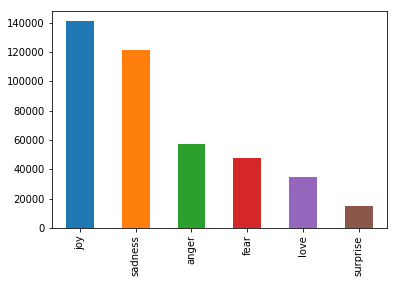

In [9]:
# load data
data = ph.load_from_pickle(directory="data/merged_training.pkl")
data.emotions.value_counts().plot.bar()

In [10]:
data.head(10)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
18231,i find myself frustrated with christians becau...,love
10714,i am one of those people who feels like going ...,joy
35177,i feel especially pleased about this as this h...,joy
122177,i was struggling with these awful feelings and...,joy
26723,i feel so enraged but helpless at the same time,anger


### 3.1 Preprocessing Data
In the next steps we are going to create tokenize the text, create index mapping for words, and also construct a vocabulary. 

#### Tokenization and Sampling

In [11]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(n=50000);

#### Constructing Vocabulary and Index-Word Mapping

In [12]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [16]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aa',
 'aaa',
 'aaaaaaaaaaaaaaaaggghhhh',
 'aaaaall',
 'aaaand',
 'aaradhya',
 'aaron',
 'aashiqui',
 'ab']

### 3.2 Converting Data into Tensors 
For convenience we would like to convert the data into tensors. 

In [17]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [18]:
# examples of what is in the input tensors
input_tensor[0:2]

[[11503,
  3362,
  6829,
  26812,
  15723,
  17689,
  11766,
  24088,
  18414,
  16507,
  16822,
  9190,
  11291,
  26812,
  8667,
  6770,
  11766,
  15723,
  22504],
 [11503,
  19743,
  24088,
  14496,
  14234,
  11766,
  10867,
  865,
  16507,
  667,
  16507,
  24088,
  24380,
  11503,
  26325,
  16609,
  20769,
  15723,
  9410,
  27106,
  865,
  11503,
  3397,
  10876,
  3214,
  8660,
  1,
  25058,
  16507,
  10212,
  24622,
  10909,
  8059,
  24232,
  21437,
  1,
  10689,
  2332,
  865,
  11503,
  6249,
  8081,
  8768,
  16507,
  10909,
  2079,
  865,
  12917,
  328,
  24206,
  14386,
  15723,
  21849,
  5348]]

### 3.3 Padding data
In order to train our recurrent neural network later on in the notebook, it is required padding to generate inputs of same length.

In [19]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [20]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

68


In [21]:
# Padding the input and output tensor to the maximum length
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                             maxlen=max_length_inp,
                                                             padding='post')

In [40]:
input_tensor[0:2]

array([[11503,  3362,  6829, 26812, 15723, 17689, 11766, 24088, 18414,
        16507, 16822,  9190, 11291, 26812,  8667,  6770, 11766, 15723,
        22504,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [11503, 19743, 24088, 14496, 14234, 11766, 10867,   865, 16507,
          667, 16507, 24088, 24380, 11503, 26325, 16609, 20769, 15723,
         9410, 27106,   865, 11503,  3397, 10876,  3214,  8660,     1,
        25058, 16507, 10212, 24622, 10909,  8059, 24232, 21437,     1,
        10689,  2332,   865, 11503,  6249,  8081,  8768, 16507, 10909,
         2079,   865, 12917,   328, 24206, 14386, 15723, 21849,  5348,
            0,     0,     0,     

### 3.4 Binarization
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [23]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [24]:
target_tensor[0:2] 

array([[0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0]])

In [30]:
data[0:2]

,text,emotions,token_size
11677,i can do without my phone in the presence of o...,sadness,19
41836,i remember the many lunches in hell and of all...,anger,54


In [26]:
get_emotion = lambda t: np.argmax(t)

In [27]:
get_emotion(target_tensor[0])

4

In [32]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [35]:
emotion_dict[get_emotion(target_tensor[0])]

'sadness'

### 3.5 Split data
We would like to split our data into a train and validation set. In addition, we also want a holdout dataset (test set) for evaluating the models.

In [36]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

### 3.6 Data Loader
We can also load the data into a data loader, which makes it easy to **manipulate the data**, **create batches**, and apply further **transformations**. In TensorFlow we can use the `tf.data` function.

In [37]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, 
                                                    target_tensor_train)).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, 
                                                  target_tensor_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, 
                                                    target_tensor_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [38]:
# checking minibatch
print(train_dataset)
print(val_dataset)
print(test_dataset)

<BatchDataset shapes: ((64, 68), (64, 6)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((64, 68), (64, 6)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((64, 68), (64, 6)), types: (tf.int32, tf.int64)>


## 4. Model
After the data has been preprocessed, transformed and prepared it is now time to construct the model or the so-called computation graph that will be used to train our classification models. We are going to use a gated recurrent neural network (GRU), which is considered a more efficient version of a basic RNN. The figure below shows a high-level overview of the model details. 

![alt txt](img/gru-model.png)

### 4.1 Constructing the Model
Below we construct our model:

In [41]:
### define the GRU component
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='relu', 
                               recurrent_initializer='glorot_uniform')

### Build the model
class EmoGRU(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        
        # layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.gru = gru(self.hidden_units)
        self.fc = tf.keras.layers.Dense(output_size)
        
    def call(self, x, hidden):
        x = self.embedding(x) # batch_size X max_len X embedding_dim
        output, state = self.gru(x, initial_state = hidden) #  batch_size X max_len X hidden_units
        out = output[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out) # batch_size X max_len X output_size
        return out, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.hidden_units))

### 4.1 Pretesting model
Since eager execution is enabled we can print the output of the model by passing a sample of the dataset and making sure that the dimensions of the outputs are as expected.

In [42]:
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)

# initialize the hidden state of the RNN
hidden = model.initialize_hidden_state()

# testing for the first batch only then break the for loop
# Potential bug: out is not randomized enough
for (batch, (inp, targ)) in enumerate(train_dataset):
    out, state = model(inp, hidden)
    print(out.shape) 
    break

(64, 6)


## 5. Training the Model
Now that we have tested the model, it is time to train it. We will define our optimization algorithm, learning rate, and other necessary information to train the model.

In [43]:
optimizer = tf.train.AdamOptimizer()

def loss_function(y, prediction):
    return tf.losses.softmax_cross_entropy(y, logits=prediction)

def accuracy(y, yhat):
    #compare the predictions to the truth
    yhat = tf.argmax(yhat, 1).numpy()
    y    = tf.argmax(y   , 1).numpy()
    return np.sum(y == yhat)/len(y)

In [44]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    hidden = model.initialize_hidden_state()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ)) in enumerate(train_dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            predictions,_ = model(inp, hidden)
            loss += loss_function(targ, predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        batch_accuracy = accuracy(targ, predictions)
        train_accuracy += batch_accuracy
        
        gradients = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradients, model.variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
            
    ### Validating
    hidden = model.initialize_hidden_state()

    for (batch, (inp, targ)) in enumerate(val_dataset):        
        predictions,_ = model(inp, hidden)        
        batch_accuracy = accuracy(targ, predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3018
Epoch 1 Batch 100 Val. Loss 0.2750
Epoch 1 Batch 200 Val. Loss 0.2609
Epoch 1 Batch 300 Val. Loss 0.1847
Epoch 1 Batch 400 Val. Loss 0.0389
Epoch 1 Batch 500 Val. Loss 0.0250
Epoch 1 Batch 600 Val. Loss 0.0175
Epoch 1 Loss 0.1530 -- Train Acc. 0.6361 -- Val Acc. 0.9319
Time taken for 1 epoch 41.33251762390137 sec

Epoch 2 Batch 0 Val. Loss 0.0263
Epoch 2 Batch 100 Val. Loss 0.0195
Epoch 2 Batch 200 Val. Loss 0.0247
Epoch 2 Batch 300 Val. Loss 0.0213
Epoch 2 Batch 400 Val. Loss 0.0381
Epoch 2 Batch 500 Val. Loss 0.0204
Epoch 2 Batch 600 Val. Loss 0.0086
Epoch 2 Loss 0.0208 -- Train Acc. 0.9358 -- Val Acc. 0.9431
Time taken for 1 epoch 41.09313082695007 sec

Epoch 3 Batch 0 Val. Loss 0.0228
Epoch 3 Batch 100 Val. Loss 0.0345
Epoch 3 Batch 200 Val. Loss 0.0262
Epoch 3 Batch 300 Val. Loss 0.0169
Epoch 3 Batch 400 Val. Loss 0.0142
Epoch 3 Batch 500 Val. Loss 0.0175
Epoch 3 Batch 600 Val. Loss 0.0194
Epoch 3 Loss 0.0172 -- Train Acc. 0.9425 -- Val Acc. 0.9393

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6984192   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
cu_dnngru (CuDNNGRU)         multiple                  3938304   
_________________________________________________________________
dense (Dense)                multiple                  6150      
Total params: 10,928,646
Trainable params: 10,928,646
Non-trainable params: 0
_________________________________________________________________


## 6. Evaluation on the Testing Data
Now we will evaluate the model with the holdout dataset.

In [57]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

hidden = model.initialize_hidden_state()

for (batch, (inp, targ)) in enumerate(test_dataset):        
    predictions,_ = model(inp, hidden)        
    batch_accuracy = accuracy(targ, predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy/TEST_N_BATCH)

Test Accuracy:  0.9326923076923077


### 6.1 Confusion Matrix
The test accuracy alone is not an interesting performance metric in this case. Let's plot a confusion matrix to get a drilled down view of how the model is performing with regards to each emotion.

Default Classification report
             precision    recall  f1-score   support

      anger       0.96      0.90      0.93       687
       fear       0.82      0.96      0.88       532
        joy       0.94      0.97      0.96      1765
       love       0.89      0.79      0.84       425
    sadness       0.97      0.97      0.97      1405
   surprise       0.89      0.66      0.76       178

avg / total       0.93      0.93      0.93      4992


Accuracy:
0.9326923076923077
Correct Predictions:  4656
precision: 0.91
recall: 0.88
f1: 0.89

confusion matrix
 [[ 621   36    3    1   26    0]
 [   6  511    1    0    5    9]
 [   5    2 1711   39    4    4]
 [   1    0   86  336    2    0]
 [  14   29    2    0 1359    1]
 [   0   46   14    0    0  118]]
(row=expected, col=predicted)


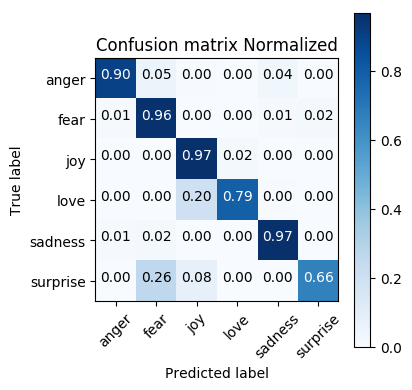

In [73]:
import helpers.evaluate as ev
evaluator = ev.Evaluate()
import pandas as pd

final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p)

predictions = [np.argmax(p).item() for p in final_predictions]
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

evaluator.evaluate_class(model_test_result.emotion, test.emotion );

## Final Words
You have learned how to perform neural-based emotion recognition using RNNs. There are many things you can do after you have completed this tutorial. You can attempt the exercises outlined in the "Outline" section of this notebook. You can also try other types of neural architectures such as LSTMs, Bi-LSTMS, attentions models, and CNNs. In addition, you can also store the models and conduct transfer learning to other emotion-related tasks. 


---

## References

- [Introduction to what is a Tensor](https://www.youtube.com/watch?v=hCSjWCVrphc&t=1137s)
- [Deep Learning for NLP](https://docs.google.com/presentation/d/1cf2H1qMvP1rdKUF5000ifOIRv1_b0bvj0ZTVL7-RaVE/edit?usp=sharing)
- [Enable Eager Execution on TensorFlow](https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/Eager_Execution_Gradient_.ipynb)
- [Basic Text Classification](https://www.tensorflow.org/tutorials/keras/basic_text_classification)
- [Deep Learning for NLP: An Overview of Recent Trends](https://medium.com/dair-ai/deep-learning-for-nlp-an-overview-of-recent-trends-d0d8f40a776d)